In [ ]:
import matplotlib.pyplot as plt

START_TIME = 1.0
BW = 100e9

In [ ]:
#@title
def getPctl(a, p):
    i = int(len(a) * p)
    return a[i]

In [ ]:
#@title
def readLog(filename, num_hosts):
  retval = {}
  retval['q_times_host'] = [[] for i in range(num_hosts)]
  retval['q_sizes_host'] = [[] for i in range(num_hosts)]
  retval['q_times_sw'] = [[] for i in range(num_hosts)]
  retval['q_sizes_sw'] = [[] for i in range(num_hosts)]
  retval['pru_times_host'] = [[] for i in range(num_hosts)]
  retval['pru_vals_host'] = [[] for i in range(num_hosts)]
  retval['pru_times_sw'] = [[] for i in range(num_hosts)]
  retval['pru_vals_sw'] = [[] for i in range(num_hosts)]
  retval['sm_times_host'] = [[] for i in range(num_hosts)]
  retval['sm_vals_host'] = [[] for i in range(num_hosts)]
  retval['sm_times_sw'] = [[] for i in range(num_hosts)]
  retval['sm_vals_sw'] = [[] for i in range(num_hosts)]
  with open(filename, 'r') as f:
    for line in f:
      queue_log = line.split()
      try:
        time = float(queue_log[1])*1e-9 - START_TIME # in seconds
        host = int(queue_log[2])
      except:
        continue

      if (queue_log[0] == 'que'):
        if (queue_log[3] == '0'):
          retval['q_times_host'][host].append(time)
          retval['q_sizes_host'][host].append(float(queue_log[4]) * 8.0 / BW * 1e6) # in usec
        elif (queue_log[3] == '1'):
          retval['q_times_sw'][host].append(time)
          retval['q_sizes_sw'][host].append(float(queue_log[4]) * 8.0 / BW * 1e6) # in usec
      elif (queue_log[0] == 'pru'):
        if (queue_log[3] == '0'):
          retval['pru_times_host'][host].append(time)
          retval['pru_vals_host'][host].append(int(queue_log[4]))
        elif (queue_log[3] == '1'):
          retval['pru_times_sw'][host].append(time)
          retval['pru_vals_sw'][host].append(int(queue_log[4]))
      elif (queue_log[0] == 'abs'):
        if (queue_log[3] == '0'):
          retval['sm_times_host'][host].append(time)
          retval['sm_vals_host'][host].append(int(queue_log[4]))
        elif (queue_log[3] == '1'):
          retval['sm_times_sw'][host].append(time)
          retval['sm_vals_sw'][host].append(int(queue_log[4]))
      else:
        print('ERROR: Unknown type of log: ' + line)
  return retval

In [ ]:
# workload = 'Google_RPC_read'
workload = 'Facebook_Hadoop'
note = '_dummy_noAiAfterBts' # Should start with a _
load = 0.8
simIdx = 0
nHost = 32
simulateSingleReceiver = True

trace_path = 'outputs/bolt-star-topo/'
trace_path += workload + '_load-' + str(int(load*100)) + 'p'
trace_path += '_nHost-' + str(nHost)

trace_path += '_' + str(simIdx)
# trace_path += '_MSGAGG'

if BW == 100e9:
  rate_info = '_100G'
else:
  rate_info = ''

log_files = {
    'Bolt' : trace_path + '_DEFAULT' + rate_info + note + '.qlen',
    # 'Swift': trace_path + '_SWIFT' + rate_info + '.qlen'
}

In [ ]:
#@title
data = {}
for algo, log_filename in log_files.items():
  data[algo] = readLog(log_files[algo], nHost)
  data[algo]['q_sizes_all'] = []
  for sw_q_sizes in data[algo]['q_sizes_sw']:
    data[algo]['q_sizes_all'] += sw_q_sizes
    if (simulateSingleReceiver):
      break
  if (not simulateSingleReceiver):
    for host_q_sizes in data[algo]['q_sizes_host']:
      data[algo]['q_sizes_all'] += host_q_sizes
  data[algo]['q_sizes_all'].sort()

In [ ]:
#@title
percentiles = [0.5, 0.9, 0.99, 0.999]
plot_q_size_dist = False
for percentile in percentiles:
  print('{}%ile queue size:'.format(percentile*100))
  for algo, d in data.items():
    if (len(d['q_sizes_all']) > 0):
     tail_q = getPctl(d['q_sizes_all'], percentile)
     print('\t{}: {:.3f}usec'.format(algo, tail_q))
     plot_q_size_dist =  True

50.0%ile queue size:
	Bolt: 1.200usec
90.0%ile queue size:
	Bolt: 4.400usec
99.0%ile queue size:
	Bolt: 7.402usec
99.9%ile queue size:
	Bolt: 10.789usec


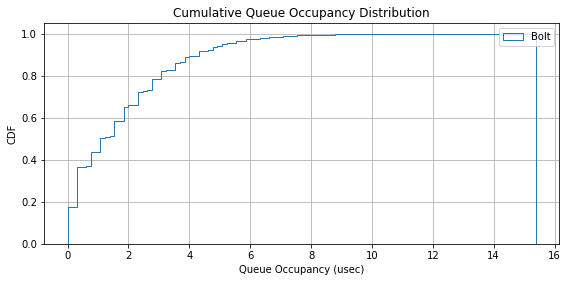

In [ ]:
#@title
if (plot_q_size_dist):
  plt.figure(figsize=(8,4))
  for algo, d in data.items():
    plt.hist(d['q_sizes_all'], bins = 100, cumulative=True, density=True, 
             histtype='step', label=algo)
  plt.legend()
  plt.xlabel('Queue Occupancy (usec)')
  plt.ylabel('CDF')
  plt.title('Cumulative Queue Occupancy Distribution')
  plt.grid()
  plt.tight_layout()

  plt.show()

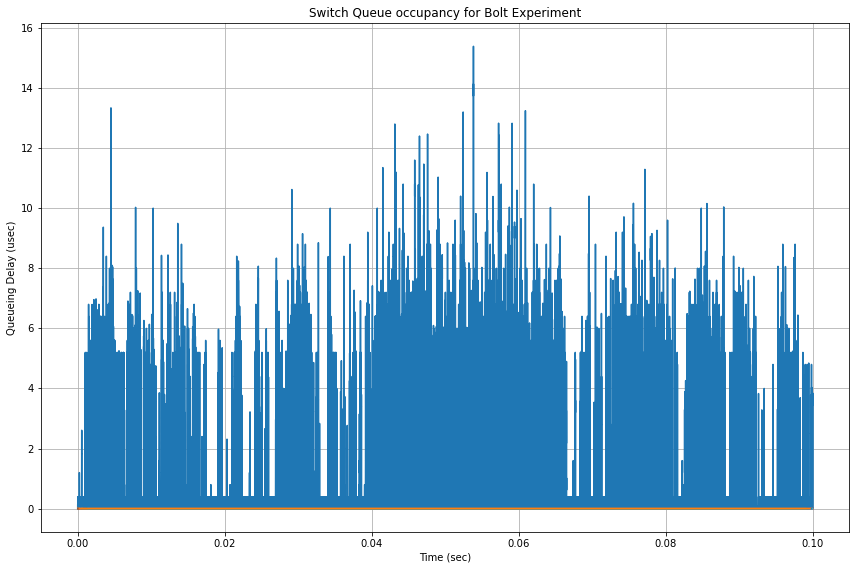

In [ ]:
#@title
if (plot_q_size_dist):
  plt.figure(figsize=(12,8))
  tot_subplots = len(data.keys())
  subplot_idx = 0

  for algo, d in data.items():
    subplot_idx += 1
    plt.subplot(tot_subplots,1,subplot_idx)
    for host in range(nHost):
      plt.step(d['q_times_sw'][host], d['q_sizes_sw'][host], where='post')
    plt.title("Switch Queue occupancy for {} Experiment".format(algo))
    plt.xlabel('Time (sec)')
    plt.ylabel('Queueing Delay (usec)')
    plt.grid()
    plt.tight_layout()

  plt.show()

In [ ]:
#@title
if (plot_q_size_dist):
  print('Average Idle Link rates:')
  for algo, d in data.items():
    nHost_to_account = 1 if simulateSingleReceiver else nHost
    data[algo]['empty_q_rate'] = [_ for i in range(nHost_to_account)]
    for host in range(nHost_to_account):
      emtpy_q_times = 0
      if (len(d['q_sizes_sw'][host]) != 0):
        for i in range(len(d['q_sizes_sw'][host])-1):
          if (d['q_sizes_sw'][host][i] == 0):
            emtpy_q_times += d['q_times_sw'][host][i+1] - d['q_times_sw'][host][i]
        duration = (max(d['q_times_sw'][host]) - min(d['q_times_sw'][host]))
        data[algo]['empty_q_rate'][host] = emtpy_q_times / duration * 100.
      else:
        data[algo]['empty_q_rate'][host] = 0

    ave_empty_q_rate = sum(data[algo]['empty_q_rate']) / nHost_to_account
    print('\t{}: {:.3f}%'.format(algo, ave_empty_q_rate))

Average Idle Link rates:
	Bolt: 47.323%


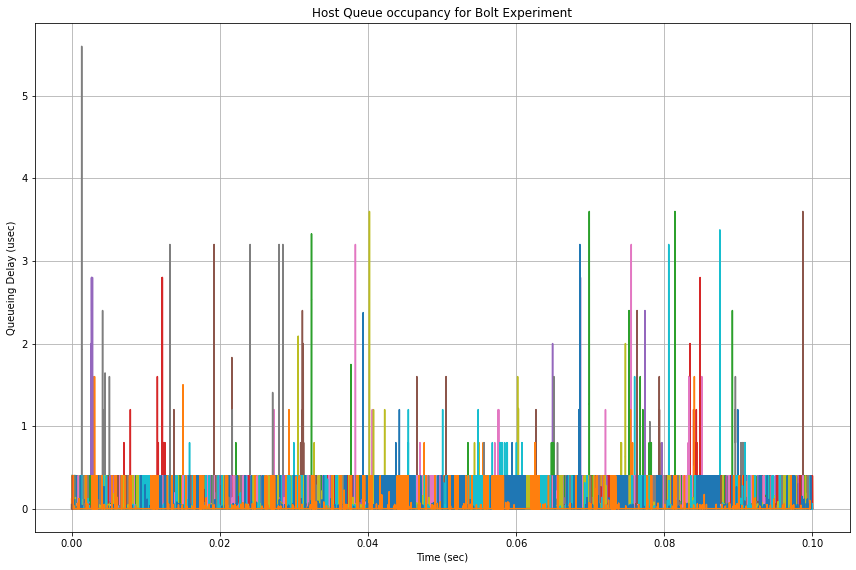

In [ ]:
#@title
if (plot_q_size_dist):
  plt.figure(figsize=(12,8))
  tot_subplots = len(data.keys())
  subplot_idx = 0

  for algo, d in data.items():
    subplot_idx += 1
    plt.subplot(tot_subplots,1,subplot_idx)
    for host in range(nHost):
      plt.step(d['q_times_host'][host], d['q_sizes_host'][host], where='post')
    plt.title("Host Queue occupancy for {} Experiment".format(algo))
    plt.xlabel('Time (sec)')
    plt.ylabel('Queueing Delay (usec)')
    plt.grid()
    plt.tight_layout()

  plt.show()

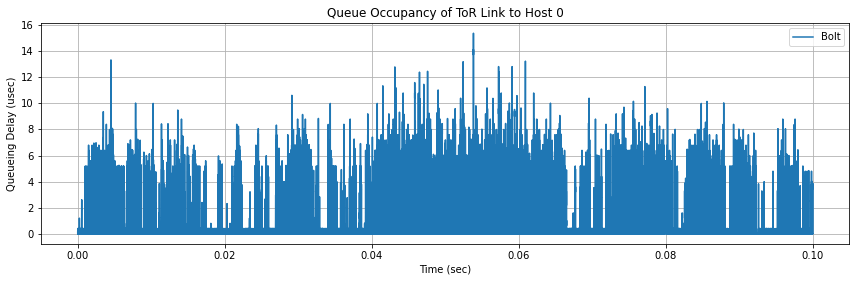

In [ ]:
#@title
if (plot_q_size_dist):
  for host in range(nHost):
    plt.figure(figsize=(12,4))
    for algo, d in data.items():
      plt.step(d['q_times_sw'][host], d['q_sizes_sw'][host], label=algo, where='post')
    # plt.xlim([0.45,0.5])
    plt.legend(loc='upper right')
    plt.title("Queue Occupancy of ToR Link to Host {}".format(host))
    plt.xlabel('Time (sec)')
    plt.ylabel('Queueing Delay (usec)')
    plt.grid()
    plt.tight_layout()
    plt.show()
    if (simulateSingleReceiver):
      break

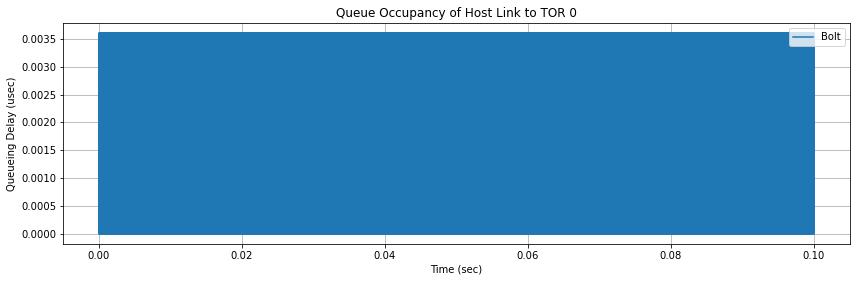

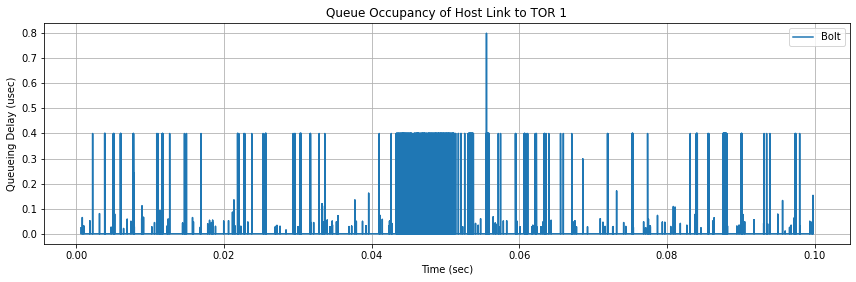

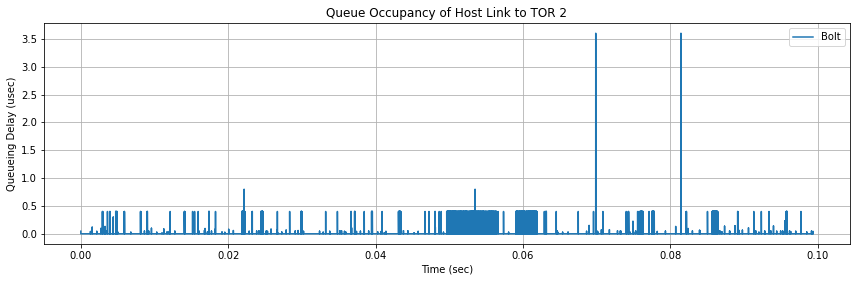

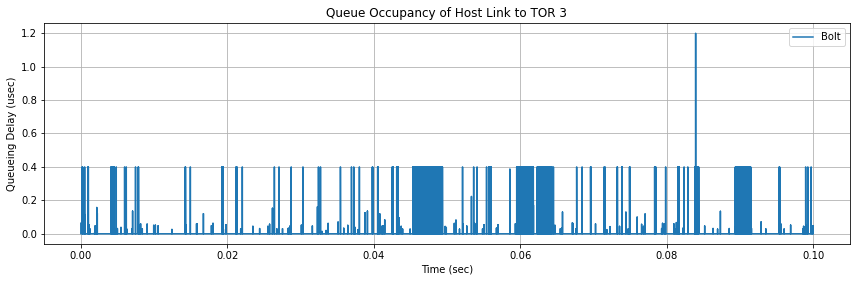

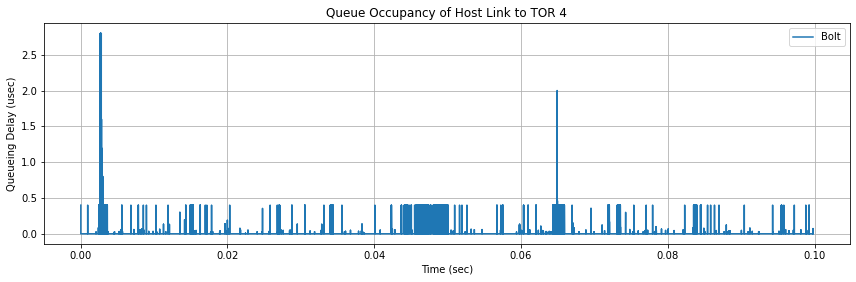

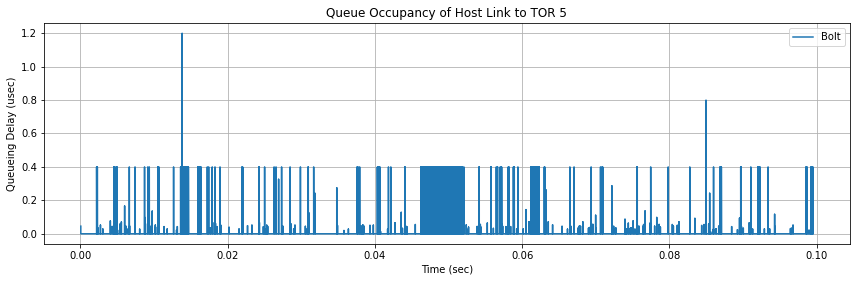

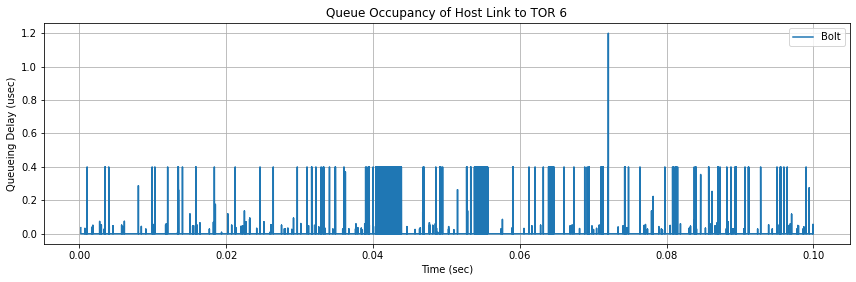

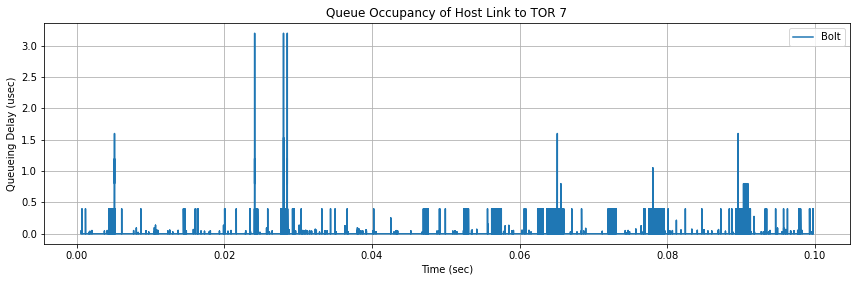

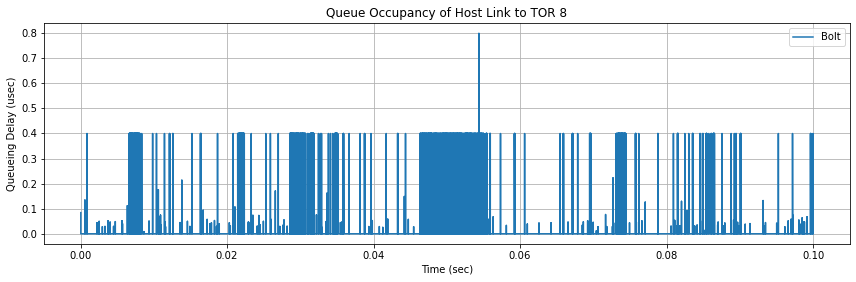

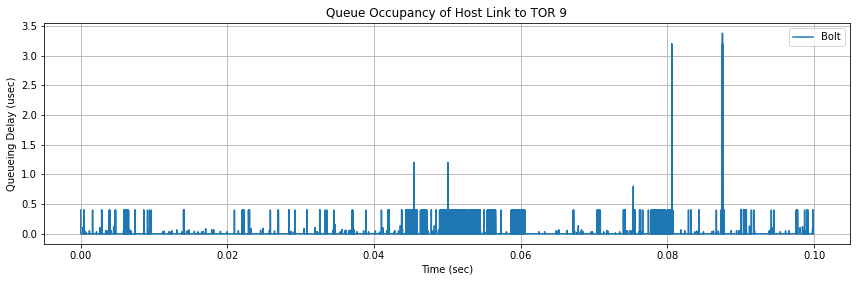

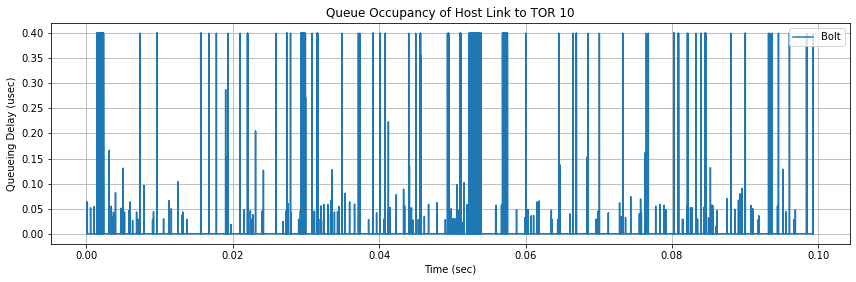

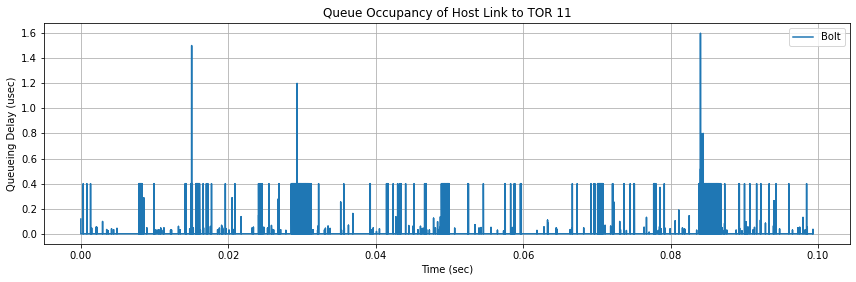

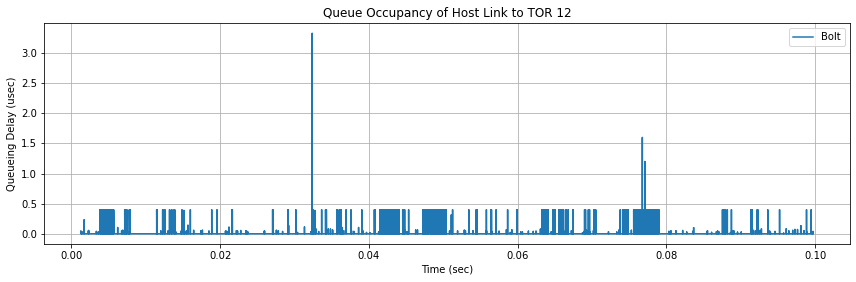

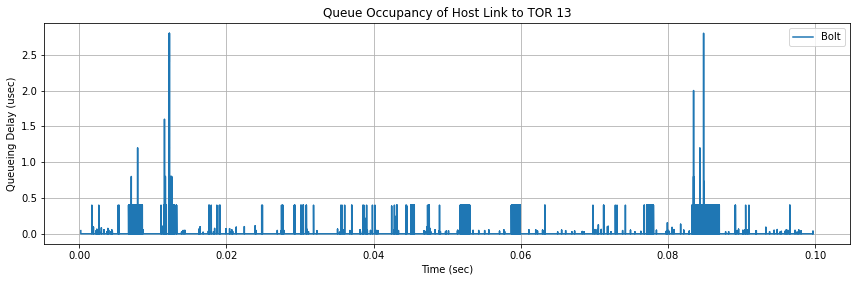

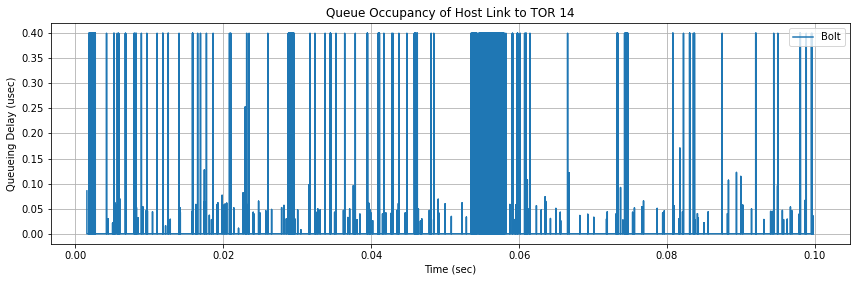

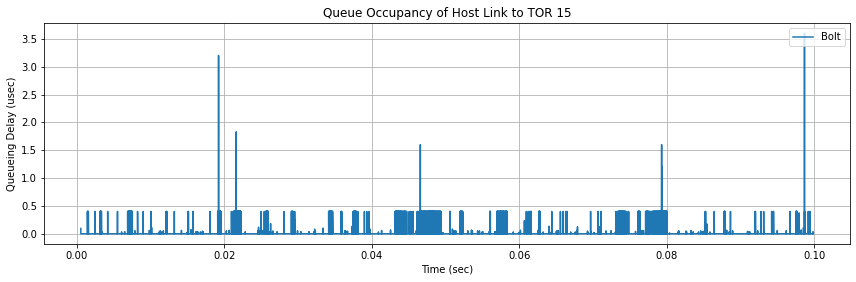

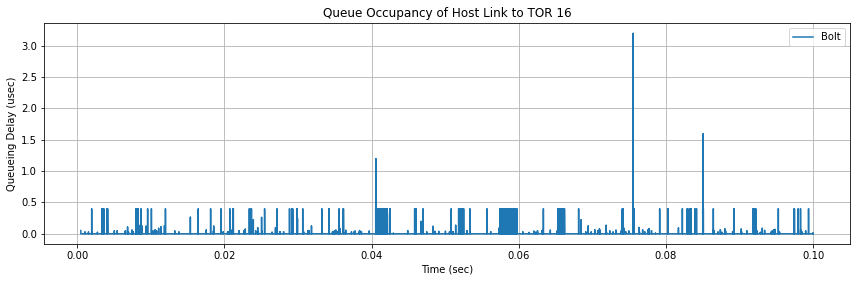

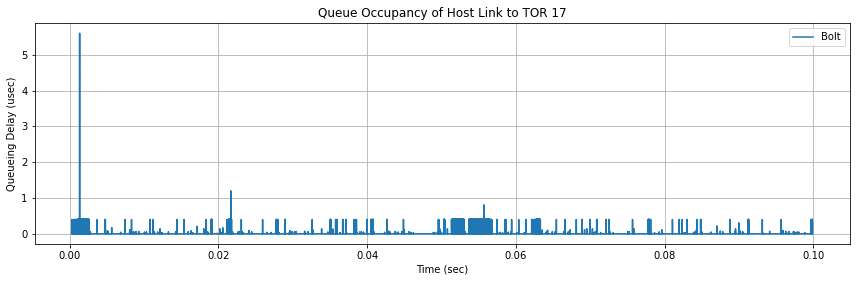

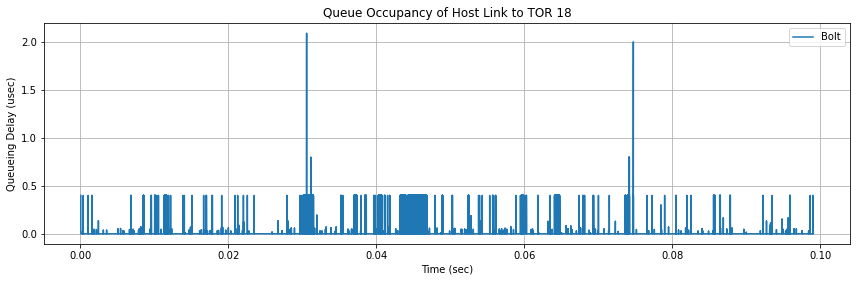

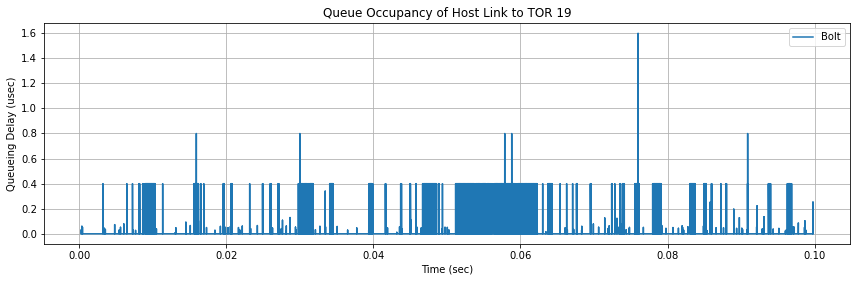

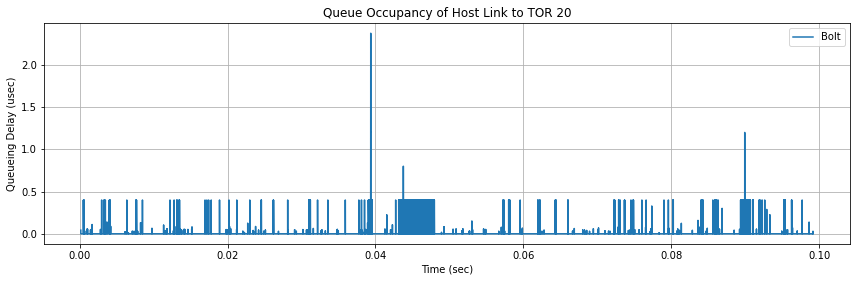

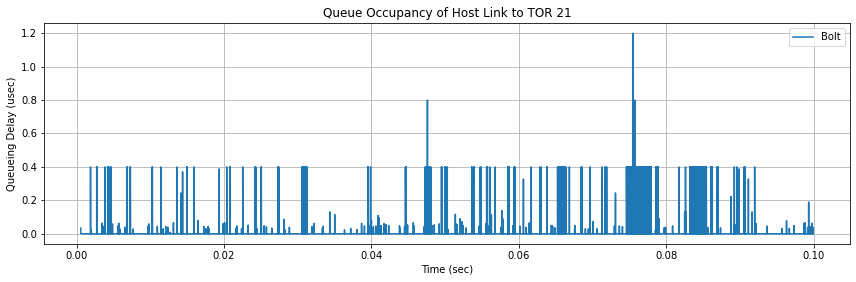

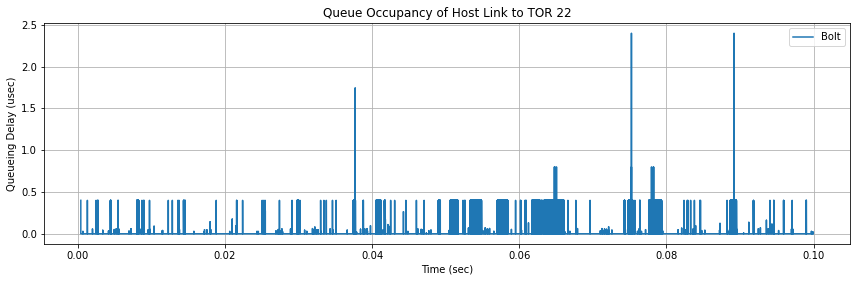

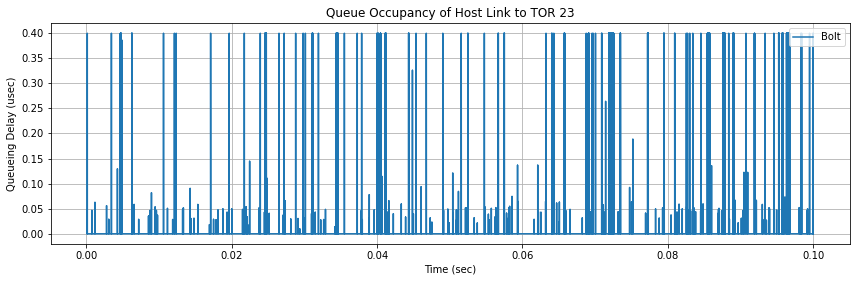

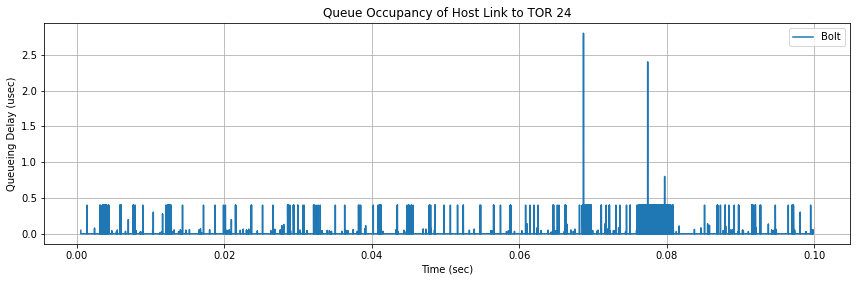

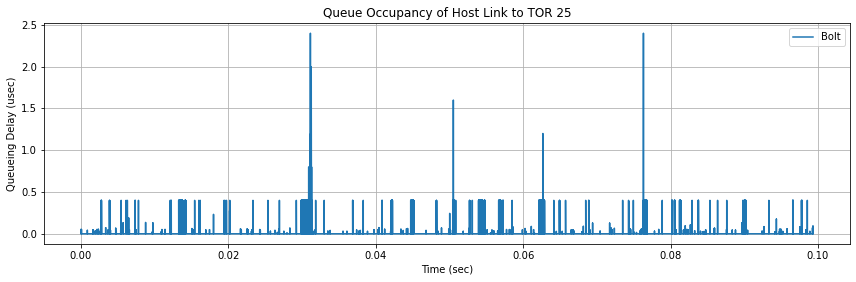

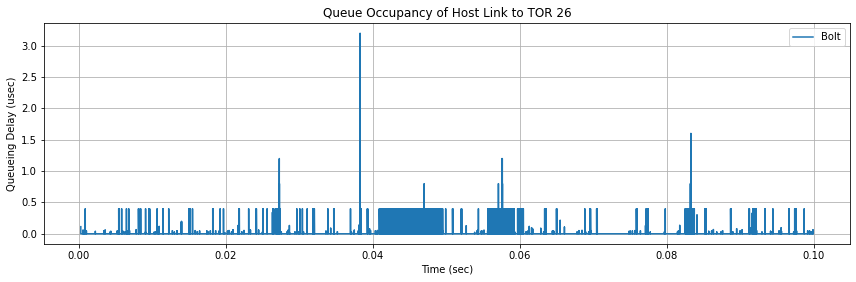

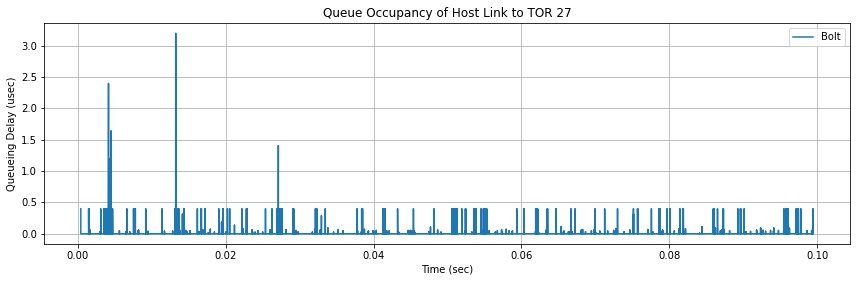

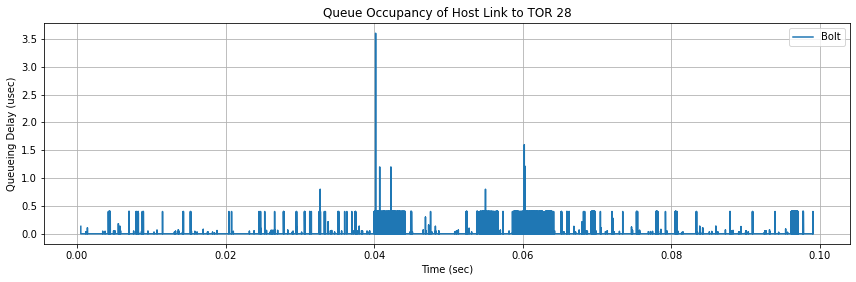

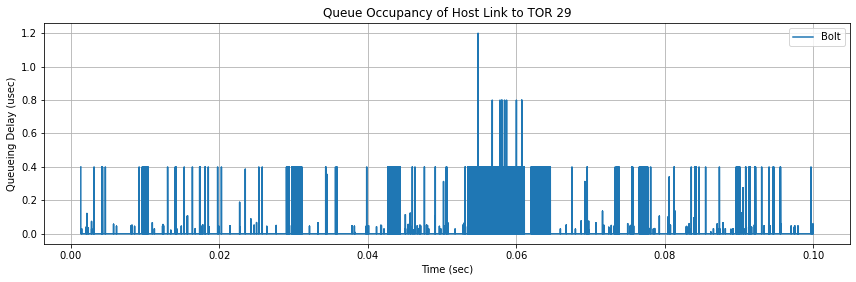

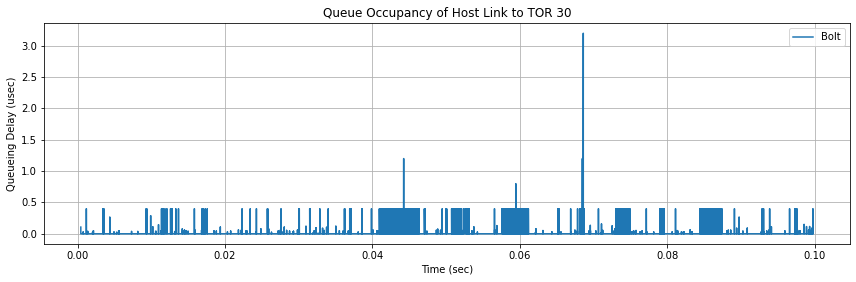

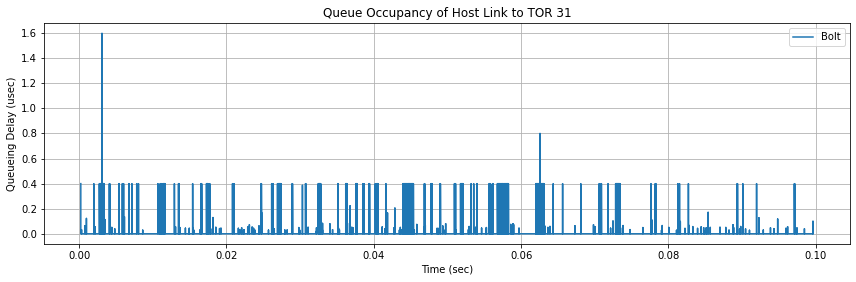

In [ ]:
#@title
if (plot_q_size_dist):
  for host in range(nHost):
    plt.figure(figsize=(12,4))
    for algo, d in data.items():
      plt.step(d['q_times_host'][host], d['q_sizes_host'][host], 
               label=algo, where='post')
    # plt.xlim([0.45,0.5])
    plt.legend(loc='upper right')
    plt.title("Queue Occupancy of Host Link to TOR {}".format(host))
    plt.xlabel('Time (sec)')
    plt.ylabel('Queueing Delay (usec)')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
#@title
plot_pru_tokens = False
for algo, d in data.items():
  for host in range(nHost):
    if (len(d['pru_vals_sw'][host]) > 0):
      plot_pru_tokens = True
      break
  else:
      continue  # only executed if the inner loop did NOT break
  break  # only executed if the inner loop DID break

In [ ]:
#@title
if (plot_pru_tokens):
  for host in range(nHost):
    plt.figure(figsize=(12,4))
    for algo, d in data.items():
      plt.step(d['pru_times_sw'][host], d['pru_vals_sw'][host], 
               label=algo, where='post')
    # plt.xlim([0.45,0.5])
    plt.axhline(y=12.5, color='r', linestyle='-', label='BDP')
    plt.legend(loc='upper right')
    plt.title("PRU Token value of TOR Link to Host {}".format(host))
    plt.xlabel('Time (sec)')
    plt.ylabel('PRU Token Count')
    plt.grid()
    plt.tight_layout()
    plt.show()
    if (simulateSingleReceiver):
      break

In [ ]:
#@title
if (plot_pru_tokens):
  for host in range(nHost):
    plt.figure(figsize=(12,4))
    for algo, d in data.items():
      plt.step(d['pru_times_host'][host], d['pru_vals_host'][host], 
               label=algo, where='post')
    # plt.xlim([0.45,0.5])
    plt.axhline(y=12.5, color='r', linestyle='-', label='BDP')
    plt.legend(loc='upper right')
    plt.title("PRU Token value of Host Link to TOR {}".format(host))
    plt.xlabel('Time (sec)')
    plt.ylabel('PRU Token Count')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
#@title
if (plot_pru_tokens):
  for host in range(nHost):
    plt.figure(figsize=(12,8))
    ax1 = plt.subplot(2,2,1)
    for algo, d in data.items():
      plt.step(d['q_times_sw'][host], d['q_sizes_sw'][host], 
               label=algo, where='post')
    # plt.xlim([0.45,0.5])
    plt.legend(loc='upper right')
    plt.title("Queue Occupancy of TOR Link to Host {}".format(host))
    plt.xlabel('Time (sec)')
    plt.ylabel('Queuing Delay (usec)')
    plt.grid()
    plt.tight_layout()
    ax3 = plt.subplot(2,2,3, sharex=ax1)
    for algo, d in data.items():
      plt.step(d['pru_times_sw'][host], d['pru_vals_sw'][host], 
               label=algo, where='post')
    # plt.xlim([0.,0.0005])
    plt.axhline(y=12.5, color='r', linestyle='-', label='BDP')
    plt.legend(loc='upper right')
    plt.title("PRU Token value of TOR Link to Host {}".format(host))
    plt.xlabel('Time (sec)')
    plt.ylabel('PRU Token Count')
    plt.grid()
    plt.tight_layout()
    ax2 = plt.subplot(2,2,2, sharey=ax1)
    for algo, d in data.items():
      plt.step(d['q_times_host'][host], d['q_sizes_host'][host], 
               label=algo, where='post')
    # plt.xlim([0.45,0.5])
    plt.legend(loc='upper right')
    plt.title("Queue Occupancy of Host Link to TOR {}".format(host))
    plt.xlabel('Time (sec)')
    plt.ylabel('Queuing Delay (usec)')
    plt.grid()
    plt.tight_layout()
    ax4 = plt.subplot(2,2,4, sharex=ax2, sharey=ax3)
    for algo, d in data.items():
      plt.step(d['pru_times_host'][host], d['pru_vals_host'][host], 
               label=algo, where='post')
    # plt.xlim([0.,0.0005])
    plt.axhline(y=12.5, color='r', linestyle='-', label='BDP')
    plt.legend(loc='upper right')
    plt.title("PRU Token value of Host Link to TOR {}".format(host))
    plt.xlabel('Time (sec)')
    plt.ylabel('PRU Token Count')
    plt.grid()
    plt.tight_layout()
    
    plt.show()
    if (simulateSingleReceiver):
      break